In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import h5py
from PIL import Image
import numpy as np
import cupy as cp
import time

import scipy
from scipy.optimize import minimize
from scipy.ndimage import gaussian_filter
from scipy import ndimage
from scipy import interpolate

from skimage.morphology import binary_dilation
from skimage.morphology import skeletonize, opening, closing, erosion, dilation, disk
from skimage.transform import hough_line, hough_line_peaks
from skimage.feature import canny
from skimage.morphology import convex_hull_image
from skimage.restoration import inpaint
from skimage import feature

## GPU info

In [2]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

# HIO

In [19]:
def proj_M_gpu( x, data ):

    #'''
    fft  = cp.fft.fftn(x)
    fabs = cp.abs(fft)
    whereIszero = (fabs == 0)
    result = data * fft / fabs
    result[whereIszero] = data[whereIszero]
    result[data < 0] = fft[data < 0]
    result = cp.fft.ifftn( result )
        
    return result
    #'''

    '''
    fft    = cp.fft.fftn( x )
    phi    = cp.angle( fft )
    result = data * cp.exp(1j * phi)
    diff =  cp.abs(fft) - data
    adiff = cp.abs(diff)

    result[(data<0) | (adiff < 1)] =  fft[(data<0) | (adiff<1) ]

    tol = 1e-5 #jump@

    result[(data>=0) & (adiff >=1)] = fft[(data>=0) & (adiff>=1) ] * ( data[(data>=0) & (adiff>=1)] / ( numpy.maximum( numpy.abs(fft)[(data>=0) & (adiff>=1)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cp.fft.ifftn( result )

    return result
    '''

    '''
    fft    = cp.fft.fftn( x )
    phi    = cp.angle(  fft  )
    result = data * cp.exp(1j * phi)

    #result[(data<0)] =  fft[(data<0)]

    #result[(data>=0)] = fft[(data>=0) ] * ( data[(data>=0)] / ( numpy.maximum( numpy.abs(fft)[(data>=0)] - diff[(data>=0) & (adiff>=1)]/ adiff[(data>=0) & (adiff>=1)], tol) ) )

    result = cp.fft.ifftn( result )

    #result = cp.fft.ifftn(result)
    #result
    #result[ data < 0] = -1

    return result
    '''


def ref_M( x, data ):
    proj = proj_M_gpu( x, data)
    result = 2 * proj - cp.identity(x.shape[0])
    return result

def ref_S(x, supp ):
    proj = proj_S( x, supp )
    result = 2 * proj - cp.identity(x.shape[0])
    return result


def projection_M_gpu( x, data ):
    return proj_M_gpu(x, data)

def projection_S ( x, supp ):
    y = x * supp
#     y[y.real < 0] = 0.0
#     y[y.imag > 0] = 0

    real = x.real
#     real[x.real < 0] = 0.0 
    
    imag = x.imag
#     imag[imag > 0] = 0
    
    y = real + 1j*imag
    return y * supp

def projection_N ( x, supp ):
    #y = numpy.copy(x)
    #y.imag = 0
    #return y

    y    = np.copy(x.real)
    mask = (y < 0)
    y[ mask ] = 0
    return y * supp



def HIO( initial, measure, support, niterations, beta, dev, threshold):

    shrinkWrapSubIter = niterations[1]
    gniteration       = niterations[0]

    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()

    cp.cuda.Device(dev).use()

    with cp.cuda.Device(dev):

        dsupport = cp.array(support)
        smeasure = cp.array( measure )
        x        = cp.array( initial )
        csupport = cp.array( 1-support )
        xerror   = cp.array( initial )

        iteration = 0
        sigma = 6
        initialbeta = beta

        while ( iteration < gniteration ):
            
            if (iteration % 2000 == 0):
                xerror = np.copy(x)

            y = projection_M_gpu( x, smeasure )
            x = projection_S( y, dsupport ) + projection_S( x - beta * y,  1-dsupport )

            if iteration % shrinkWrapSubIter == 0 and iteration > 0:
                z = cp.array( gaussian_filter( cp.abs(x).get(), sigma) )
                dsupport = z > ( threshold/100. ) * z.max()
                sigma = 0.99 * sigma

                beta = initialbeta + (1 - initialbeta)*(1 - np.exp(-(iteration/7)**3))
                
                if (iteration > 10000):
                    x[np.abs(x) < 0.01] = 0+1j*0
                
                if (iteration > 2000):
                    real = x.real
                    real[x.real < 0] = 0.0 

                    imag = x.imag
                    imag[imag > 0] = 0.0

                    x = real + 1j*imag
            
            if (iteration % 2000 == 0 ):
                res = x.get()
                
                plt.figure(figsize = (5,5))
                plt.imshow(np.abs(res[1*res.shape[0]//3:2*res.shape[0]//3, res.shape[1]//3:2*res.shape[1]//3]))
                plt.colorbar()
                plt.show()
                
                plt.figure(figsize = (5,5))
                plt.imshow(dsupport.get())
                plt.colorbar()
                plt.show()
                
                print(iteration, np.linalg.norm(xerror -x))
                
                
            iteration += 1

    output = x.get()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    return output

def vignetting(image,alpha=36,m=36):

    shape = image.shape

    N = 0.99 # controls thickness of null border
    x = np.linspace(-N,N,shape[1])
    y = np.linspace(-N,N,shape[0])
    X, Y = np.meshgrid(x,y)

    vignet = np.exp(-alpha*(X)**m)*np.exp(-alpha*(Y)**m)
    vignet[vignet<1e-10] = 0
    return vignet

# wavefront = propagate_beam(wavefront, object_pixel_size, wavelength,+distance) # propagate
def propagate_beam(wavefront, dx, wavelength,distance,propagator='fourier'):
    """ Propagate a wavefront using fresnel ou fourier propagator

    Args:
        wavefront : the wavefront to propagate
        dx : pixel spacing of the wavefront input
        wavelength : wavelength of the illumination
        distance : distance to propagate
        propagator (str, optional): 'fresenel' or 'fourier'. Defaults to 'fresnel'.

    Returns:
        output: propagated wavefront
    """    
    from cupy.fft import fft2, fftshift, ifftshift, ifft2

    ysize, xsize = wavefront.shape
    
    x_array = cp.linspace(-xsize/2,xsize/2-1,xsize)
    y_array = cp.linspace(-ysize/2,ysize/2-1,ysize)
    
    fx = x_array/(xsize)
    fy = y_array/(ysize)
    
    FX,FY = cp.meshgrid(fx,fy)

    if propagator == 'fourier':
        if distance > 0:
            output = fftshift(fft2(fftshift(wavefront)))
        else:
            output = ifftshift(ifft2(ifftshift(wavefront)))            
    elif propagator == 'fresnel':
        # % Calculate approx phase distribution for each plane wave component
        w = FX**2 + FY**2 
        
        # Compute FFT
        F = fftshift(fft2(fftshift(wavefront)))
        
        # % multiply by phase-shift and inverse transform 
        a = cp.exp(-1j*cp.pi*( distance*wavelength/dx**2)*w)
        
        output = ifftshift(ifft2(ifftshift(F*a)))

        phase_factor = np.exp(1j*2*np.pi*distance/wavelength) # constant phase factor (see Paganin eq 1.28)
        
    return output*phase_factor


def propagation_fourier(x,inverse=False):
    if inverse == False:
        return cp.fft.fftshift(cp.fft.fft2(x))
    else:
        return cp.fft.ifft2(cp.fft.fftshift(x))
    
def projection_F_space(fft, data):
    fabs = cp.abs(fft)
    whereIszero = (fabs == 0)
    result = data * fft / fabs
    result[whereIszero] = data[whereIszero]
    result[data < 0] = fft[data < 0]
    # result = cp.fft.ifftn( result )
    return result

def get_object_pixel(N,pixel_size,wavelength,distance):
    return wavelength*distance/(N*pixel_size)

def update_wave_upstream_modulator(modulator,wave_upstream_modulator,revised_wave_downstream_modulator,wave_downstream_modulator,alpha=1):
    return wave_upstream_modulator + alpha*np.conj(modulator)*(revised_wave_downstream_modulator-wave_downstream_modulator)/np.max(np.abs(modulator)**2)

def mean_squared_error(estimate,measurement):
    return np.sum( (estimate-measurement)**2 )/(np.sum(measurement)**2)

def corrupt_data(DP, invalid_threshold=0.1, thickness = 10, gaussian_noise=(),grid_thickness=2):
    
    mask = np.ones_like(DP)
    
    if invalid_threshold > 0:
        random_matrix = np.random.rand(*DP.shape)
        random_matrix = np.where(random_matrix > invalid_threshold, 1, 0)
        mask = mask*random_matrix
    
    if thickness > 0:
        beam_stopper = np.ones_like(DP)
        gordurinha = 10 # pixels
        beam_stopper[beam_stopper.shape[0]//2-thickness:beam_stopper.shape[0]//2+thickness,0:beam_stopper.shape[1]//2+gordurinha] = 0
        mask *= beam_stopper
    
    if gaussian_noise != ():
        mu, sigma = gaussian_noise
        noise = np.random.normal(mu, sigma, DP.shape) 
        DP += noise
        DP[DP<0] = -1
    
    if grid_thickness > 0:
        grid = np.ones_like(DP)
        offset = 0
        for i in range(5):
            offset += grid.shape[0]//5
            grid[offset-grid_thickness:offset+grid_thickness,:] = 0
            grid[:,offset-grid_thickness:offset+grid_thickness] = 0
        mask *= grid

    # if low_count_error: # add error of +-5 pixels for low count pixels

    
    # IGNORE PIXELS WITH COUNT LOWER THAN 1
    # measurement_without_modulator[measurement_without_modulator<1]=0
    # measurement[measurement<1]=0
    
    DP[mask==0] = -1
    
    # fig, ax = plt.subplots(1,2,dpi=150)
    # ax[0].imshow(mask)
    # ax[1].imshow(DP, norm=LogNorm())
    
    return DP

def create_image_from_text(text):
    from matplotlib.backends.backend_agg import FigureCanvas
    fig = plt.Figure(figsize=(2.56, 2.56), dpi=200)
    canvas = FigureCanvas(fig)
    ax = fig.subplots()
    t = ax.text(0.5, 0.5, text, fontsize=30, fontweight='heavy', ha='center', va='center')
    ax.axis('off')
    canvas.draw()
    img = 1- np.array(canvas.renderer.buffer_rgba())[:, :, 0]/255
    return img


def create_filter_values(initial_sigma,npoints,curvature=2, method='negative_curvature'):

    x = np.linspace(0,1,npoints)
    f1 = x
    f2 = 1-(x-1)**(2*curvature)
    f3 = x**(2*curvature)
    
    f1 = f1[::-1]
    f2 = f2[::-1]
    f3 = f3[::-1]

    # fig, ax = plt.subplots(dpi=150)
    # ax.plot(x,f1,label='x')
    # ax.plot(x,f2,label='1-(x-1)**(2*n)')
    # ax.plot(x,f3,label='x**(2*n)')
    # ax.legend()
    # ax.set_title(f'n={curvature}')

    if method == 'linear':
        return f1
    if method == 'negative_curvature':
        return f2
    elif method == 'positive_curvature':
        return f3



def call_shrinkwrap(img,sigma,threshold=0.5, threshold_method='max'):
    
    def gaussian_filter(img,sigma,mean=0):
        return ndimage.gaussian_filter(img, sigma)

    def apply_threshold(image,threshold,method):

        if method == 'max':
            image = np.where(image>threshold*np.max(image),1,0) 
        elif method == 'mean':
            image = np.where(image>threshold*np.mean(image),1,0) 
        elif method == 'rms':
            image = np.where(image>threshold*np.rms(image),1,0) 

        return image
    
    #TODOs:
    # - force shrinking
    # - limit number of pixels at the border to be updated
    # - set minimum fraction of pixels that support can have
    # - use range of sigma values instead of sequence from an initial value
    
    img = np.abs(img)
    
    img = gaussian_filter(img,sigma) # gaussian filter with standard deviation = sigma
    
    img = apply_threshold(img,threshold, threshold_method)
    
    return img

def CMI(initial_guess, measurement, modulator, support, iterations, pixel_size, wavelength,modulator_distance, beta=0.5, alpha=1,dev = 0,N_update=1,notCMI=False,shrinkwrap=0,sigma=5,plot=None):

    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()

    cp.cuda.Device(dev).use()

    with cp.cuda.Device(dev):

        support     = cp.array(support)
        modulator   = cp.array(modulator)
        measurement = cp.array( measurement )
        y           = cp.array( initial_guess )
        csupport    = cp.array( 1-support )

        wave_after_support_constraint = np.ones_like(y)
 
        sigma_list = create_filter_values(5,iterations,method='linear') # sigma values for shrinkwrap gaussian filter

        iteration = 0
        error = []
        while ( iteration < iterations ):
            
            if iteration < iterations*0.95:
                if plot != None and iteration % plot == 0: print(f'Iteration #{iteration}: HIO')
                wave_after_support_constraint = projection_S( y, support ) + projection_S( wave_after_support_constraint - beta * y,  1-support ) 
            else:
                if plot != None and iteration % plot == 0: print(f'Iteration #{iteration}: ER')
                wave_after_support_constraint = projection_S( y, support )
                
            # fig, ax = plt.subplots(1,2,dpi=150)
            # ax[0].imshow(cp.angle(wave_after_support_constraint).get())
            # ax[1].imshow(cp.abs(wave_after_support_constraint).get())
            # plt.show(), plt.close()
            
            if notCMI:
                wave_downstream_modulator = wave_after_support_constraint
            else:
                wave_upstream_modulator = propagate_beam(wave_after_support_constraint, pixel_size, wavelength,modulator_distance,propagator='fresnel')
                wave_downstream_modulator = wave_upstream_modulator*modulator
            # wave_downstream_modulator = wave_upstream_modulator

            if iteration % N_update == 0: # step IV of algorithm in the paper
                previous_wave_downstream_modulator = wave_downstream_modulator
            # previous_wave_downstream_modulator = wave_downstream_modulator

            if notCMI:
                wave_at_detector = propagation_fourier(wave_downstream_modulator)
            else:
                wave_at_detector = propagation_fourier(2*wave_downstream_modulator-previous_wave_downstream_modulator)
                    # wave_at_detector = propagation_fourier(wave_downstream_modulator)
                    
            error.append(mean_squared_error(wave_at_detector,measurement).get())
                
            projected_wave_at_detector = projection_F_space( wave_at_detector, measurement ) # different in the paper: downsampling
            
            if notCMI:
                revised_wave_downstream_modulator = propagation_fourier(projected_wave_at_detector,inverse=True)
            else:
                # revised_wave_downstream_modulator = propagation_fourier(projected_wave_at_detector,inverse=True)
                revised_wave_downstream_modulator = propagation_fourier(projected_wave_at_detector,inverse=True) - (wave_downstream_modulator - previous_wave_downstream_modulator)

            if notCMI:
                # previous_wave_downstream_modulator = wave_downstream_modulator # save for next iteration
                pass
            else:
                previous_wave_downstream_modulator = wave_downstream_modulator # save for next iteration
                revised_wave_upstream_modulator = update_wave_upstream_modulator(modulator,wave_upstream_modulator,revised_wave_downstream_modulator,wave_downstream_modulator,alpha) 

            if notCMI:
                y = revised_wave_downstream_modulator
            # y = propagate_beam(revised_wave_downstream_modulator, pixel_size, wavelength,-modulator_distance,propagator='fresnel')
            else:
                y = propagate_beam(revised_wave_upstream_modulator, pixel_size, wavelength,-modulator_distance,propagator='fresnel')
            
            if shrinkwrap>0:
                if iteration > shrinkwrap: 
                    # sigma = sigma_list[iteration-start_shrinkwrap]
                    # if iteration % 50 == 0: print(f'sigma = {sigma}')
                    support = call_shrinkwrap(y.get(),sigma,threshold=0.2)
                    support = cp.asarray(support)
            
            if plot != None:
                if iteration % plot == 0 or iteration == iterations-1:
                    fig, ax = plt.subplots(1,4,figsize=(14,4))
                    ax[0].imshow(cp.angle(y).get()), ax[0].set_title('Phase')
                    ax[1].imshow(cp.abs(y).get()), ax[1].set_title('Magnitude')
                    ax[2].imshow(np.abs(support.get())), ax[2].set_title('Support')
                    ax[3].plot(error,'.-'), ax[3].set_title('Error'), ax[3].set_yscale('log')
                    for ax in ax.ravel(): ax.set_xticks([]), ax.set_yticks([])
                    plt.show(), plt.close()
            
            iteration += 1
            
        else:
            print(f"{iterations} iterations done")
            
    output = y.get()

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    return output, support.get(), error

def correct_for_photon_count(data, total_flux=0, pileup_count=0):
    
    if total_flux > 0:
        factor = total_flux/np.sum(data)
        data = data*factor
        data = np.where(data<0,0,data)
        return data
    if pileup_count > 0:
        factor = pileup_count/np.max(data)
        data = data*factor
        data = np.where(data<0,0,data)
        return data   

Detector distance = 10.00 meters
Modulator distance = 0.02 meters
Energy = 9.00 keV
Pixel size = 55.00 um
Oversampling = 5.83

Sample: magnitude max = 1000.00	 magnitude min = 0.00
Sample: phase     max = 3.14	 phase min = 0.00

FT(obj): sum = 1.30e+07 	 range = 23329.50
FT(obj): max = 23329.53 	 min = 0.02 	 mean = 49.59

FT(M(obj)): sum = 1.30e+07 	 range = 6956.94
FT(M(obj)): max = 6956.98 	 min = 0.04 	 mean = 49.59

Modulator: minimum transmission = 0.804
Modulator: maximum phase shift = 1.00*pi


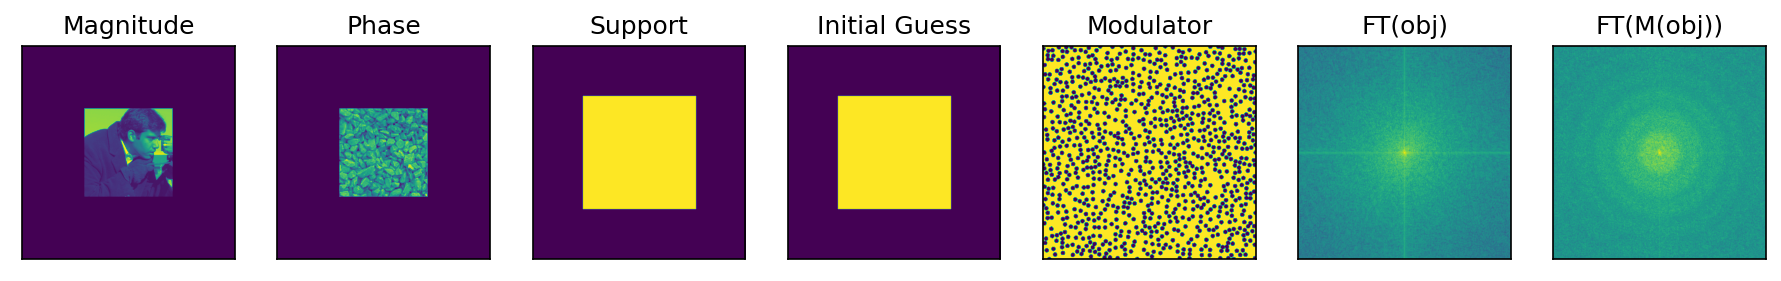

In [48]:
import random
random.seed(10)
speed_of_light, planck = 299792458, 4.135667662E-18  # Plank constant [keV*s]; Speed of Light [m/s]

# Experiment Parameters
detector_distance = 10 # meters
modulator_distance = 2e-2 # meters
energy = 9 # keV
wavelength = planck * speed_of_light / energy # meters
detector_pixel = 55e-6 # meters
total_flux_per_sec = 1.3e7 # photons
detector_pileup = 1e6 # counts/sec

print(f"Detector distance = {detector_distance:.2f} meters")
print(f"Modulator distance = {modulator_distance:.2f} meters")
print(f"Energy = {energy:.2f} keV")
print(f"Pixel size = {detector_pixel*1e6:.2f} um")


# LOAD DATA
path1 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/gravel512.npy'
path2 = '/ibira/lnls/labs/tepui/home/yuri.tonin/00000000/data/simulation_data/camera512.npy'


if 1: 
    phase = np.array( np.load(path1),dtype=np.float64) 
    magnitude = np.array( np.load(path2),dtype=np.float64)+10
else:
    phase = create_image_from_text('CAT\nSIRIUS')
    magnitude = create_image_from_text('CAT\nSIRIUS')

# fig, ax = plt.subplots(1,2,dpi=300)
# ax[0].imshow(magnitude), ax[0].set_title('Magnitude')
# ax[1].imshow(phase), ax[1].set_title('Phase')
    
# from PIL import Image 
# im = Image.fromarray(magnitude)

n_of_pixels = magnitude.shape[0]
object_pixel_size = get_object_pixel(n_of_pixels,detector_pixel,wavelength,detector_distance)

# MODULATOR OPTIONS:
if 0: # constant magnitude, random phase
    random = np.random.rand(*magnitude.shape)
    random = scipy.ndimage.gaussian_filter(random, 2)
    modulator = 2*np.pi*(2*np.pi*random/np.max(random) - np.pi)
    modulator = 1*np.exp(1j*modulator)
else:
    # modulator = np.load('modulators/modulator_300_nm.npy')
    # modulator = np.load('modulators/modulator_100_nm.npy')
    modulator = np.load('modulators/W_modulator_300_nm_error_0_nm.npy')
    # modulator = np.load('modulators/W_modulator_300_nm_error_150_nm.npy')

# fig, ax = plt.subplots(1,2,figsize=(15,10))
# ax1 = ax[0].imshow(np.abs(modulator))
# ax[0].set_title('Transmission')
# ax2 = ax[1].imshow(np.angle(modulator),cmap='viridis')
# ax[1].set_title('Phase shift')
# fig.colorbar(ax1, ax=ax[0],shrink=0.5)
# fig.colorbar(ax2, ax=ax[1],shrink=0.5)
# fig.tight_layout()
    
    
if 0: # shift modulator slightly    
    modulator = np.load('modulators/W_modulator_300_nm_error_0_nm_600x600.npy')
    center = 256
    modulator2 = modulator[center-256:center+256,center-256:center+256]
    error = 30
    center += error
    print(center+256,center-256)
    shifted_modulator = modulator[center-256:center+256,center-256:center+256]
    modulator = modulator2
    
    plt.figure(dpi = 150)
    plt.imshow(np.abs(2*modulator-shifted_modulator))

# MASK DATA FOR ADJUSTING OVERSAMPLING    
N = 75
mask = np.zeros_like(phase)
mask[2*N:-2*N,2*N:-2*N] = 1
phase = phase*mask

magnitude = np.roll(magnitude,N,axis=(0,1)) # moves the camera man face to the center
magnitude = magnitude*mask


# SUPPORT
if 1: #loose support
    N = int(1.60*N) # 2*N = tight; 1.9 = sligtly loose
    support = np.zeros_like(phase)
    support[N:-N,N:-N] = 1
else: #tight support
    support = mask # use tight support

# ADJUST PHASE AND MAGNITUDE VALUES    
phase = np.pi*phase/np.max(phase)
# phase = np.ones_like(phase)
mag_factor = 1000
magnitude = mag_factor*magnitude/np.max(magnitude)

# DEFINE OBJECT
model_object = np.abs(magnitude)*np.exp(1j*phase)

# CALCULATE FAR-FIELD DIFFRACTION PATTERN WITHOUT MODULATOR
wave_at_detector = np.fft.fftshift(np.fft.fftn(model_object))
measurement_without_modulator = np.abs(wave_at_detector)
measurement_without_modulator = correct_for_photon_count(measurement_without_modulator, total_flux=total_flux_per_sec)

# CALCULATE FAR-FIELD DIFFRACTION PATTERN WITH MODULATOR
model_object = propagate_beam(model_object, object_pixel_size, wavelength,modulator_distance,propagator='fresnel').get()
model_object = model_object*modulator
wave_at_detector = np.fft.fftshift(np.fft.fftn(model_object))
measurement = np.abs(wave_at_detector)
measurement = correct_for_photon_count(measurement, total_flux=total_flux_per_sec)

# CHOOSE INITIAL GUESS FOR ITERATIVE ALGORITHM
# initial_guess = np.random.rand(*magnitude.shape)
# initial_guess = np.ones_like(model_object)
initial_guess = support

fig, ax = plt.subplots(1,7,figsize=(15,5),dpi=150)
ax[0].imshow(magnitude), ax[0].set_title('Magnitude')
ax[1].imshow(phase), ax[1].set_title('Phase')
ax[2].imshow(support), ax[2].set_title('Support')
ax[3].imshow(np.abs(initial_guess)), ax[3].set_title('Initial Guess')
ax[4].imshow(np.angle(modulator)), ax[4].set_title('Modulator')
ax[5].imshow(measurement_without_modulator,norm=LogNorm()), ax[5].set_title('FT(obj)')
ax[6].imshow(measurement,norm=LogNorm()), ax[6].set_title('FT(M(obj))')

for ax in ax:
    ax.set_xticks([])
    ax.set_yticks([])    
    
print(f'Oversampling = {(mask.shape[0]**2)/np.sum(mask):.2f}')
print('')
print(f'Sample: magnitude max = {np.max(magnitude):.2f}\t magnitude min = {np.min(magnitude):.2f}')
print(f'Sample: phase     max = {np.max(phase):.2f}\t phase min = {np.min(phase):.2f}')
print('')
print(f'FT(obj): sum = {np.sum(measurement_without_modulator):.2e} \t range = {np.max(measurement_without_modulator)-np.min(measurement_without_modulator):.2f}')
print(f'FT(obj): max = {np.max(measurement_without_modulator):.2f} \t min = {np.min(measurement_without_modulator):.2f} \t mean = {np.mean(measurement_without_modulator):.2f}')
print('')
print(f'FT(M(obj)): sum = {np.sum(measurement):.2e} \t range = {np.max(measurement)-np.min(measurement):.2f}')
print(f'FT(M(obj)): max = {np.max(measurement):.2f} \t min = {np.min(measurement):.2f} \t mean = {np.mean(measurement):.2f}')
print('')
print(f"Modulator: minimum transmission = {np.min(np.abs(modulator)):.3f}")
print(f"Modulator: maximum phase shift = {np.max(np.abs(np.angle(modulator)))/np.pi:.2f}*pi")


### Non-corrupted data

In [49]:
N_update=2
alpha = 0.9
beta = 0.9
iterations = 300
shrinkwrap = 50 # iteration to start shrinking
device = 0

# modulator = shifted_modulator

result_CMI, final_support_CMI, error_CMI = CMI(initial_guess, measurement, modulator, support, iterations, object_pixel_size, wavelength, modulator_distance, beta, alpha, dev = 0,N_update=N_update,shrinkwrap=shrinkwrap, notCMI=False,plot=None)
result_CDI, final_support_CDI, error_CDI = CMI(initial_guess, measurement_without_modulator, modulator, support, iterations, object_pixel_size, wavelength, modulator_distance, beta, alpha, dev = 0,N_update=N_update,shrinkwrap=shrinkwrap, notCMI=True,plot=None)

300 iterations done
300 iterations done


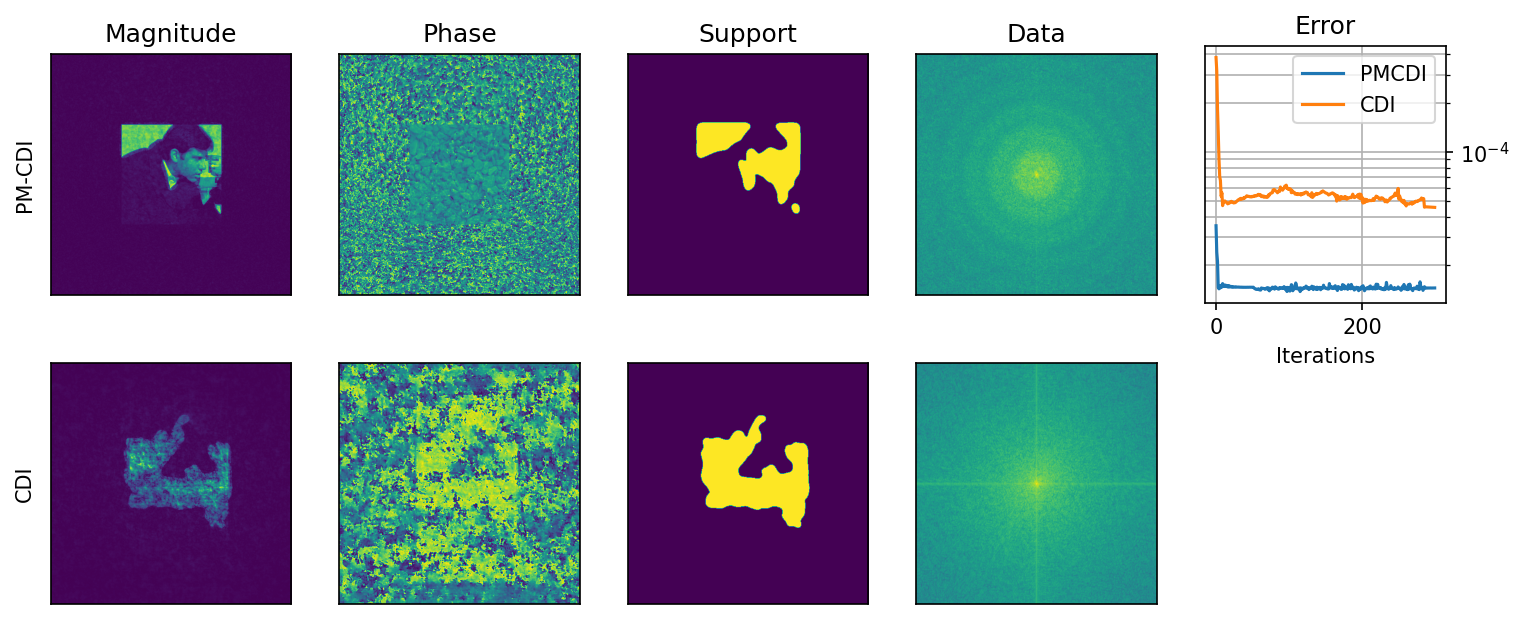

In [47]:
fig, ax = plt.subplots(2,5,figsize=(12,5),dpi=150)
ax[0,0].imshow(np.abs(result_CMI))
ax[0,0].set_title('Magnitude')
ax[0,1].imshow(np.angle(result_CMI))
ax[0,1].set_title('Phase')
ax[0,2].imshow(np.abs(final_support_CMI))
ax[0,2].set_title('Support')
ax[0,3].imshow(np.abs(measurement),norm=LogNorm())
ax[0,3].set_title('Data')
ax[0,0].set_ylabel('PM-CDI')
ax[0,4].plot(error_CMI,label='PMCDI')
ax[0,4].set_title('Error')

ax[1,0].imshow(np.abs(result_CDI))
ax[1,1].imshow(np.angle(result_CDI))
ax[1,2].imshow(np.abs(final_support_CDI))
ax[1,0].set_ylabel('CDI')
ax[1,3].imshow(np.abs(measurement_without_modulator),norm=LogNorm())
ax[0,4].plot(error_CDI,label='CDI')

ax[0,4].set_yscale('log')
ax[0,4].yaxis.set_ticks_position("right")
ax[0,4].grid(which='both')
ax[0,4].set_xlabel('Iterations')
ax[0,4].legend()
fig.delaxes(ax[1,4])

for ax0 in ax.ravel():
    if ax0 == ax[0,4] or ax0 == ax[1,4]:
        pass
    else:
        ax0.set_xticks([])
        ax0.set_yticks([]) 


## Corrupted data

In [43]:
invalid_threshold=0.02
thickness=5
gaussian_noise=()
grid_thickness=1

corrupted_measurement = corrupt_data(measurement.copy(),invalid_threshold=invalid_threshold,thickness=thickness,gaussian_noise=gaussian_noise,grid_thickness=grid_thickness)
result_CMI, final_support_CMI, error_CMI = CMI(initial_guess, corrupted_measurement, modulator, support, iterations, object_pixel_size, wavelength, modulator_distance, beta, alpha, dev = 0,N_update=N_update,shrinkwrap=shrinkwrap, notCMI=False)

corrupted_measurement_without_modulator = corrupt_data(measurement_without_modulator.copy(),invalid_threshold=invalid_threshold,thickness=thickness,gaussian_noise=gaussian_noise,grid_thickness=grid_thickness)
result_CDI,final_support_CDI, error_CDI = CMI(initial_guess, corrupted_measurement_without_modulator, modulator, support, iterations, object_pixel_size, wavelength, modulator_distance, beta, alpha, dev = 0,shrinkwrap=shrinkwrap,N_update=N_update, notCMI=True)

300 iterations done
300 iterations done


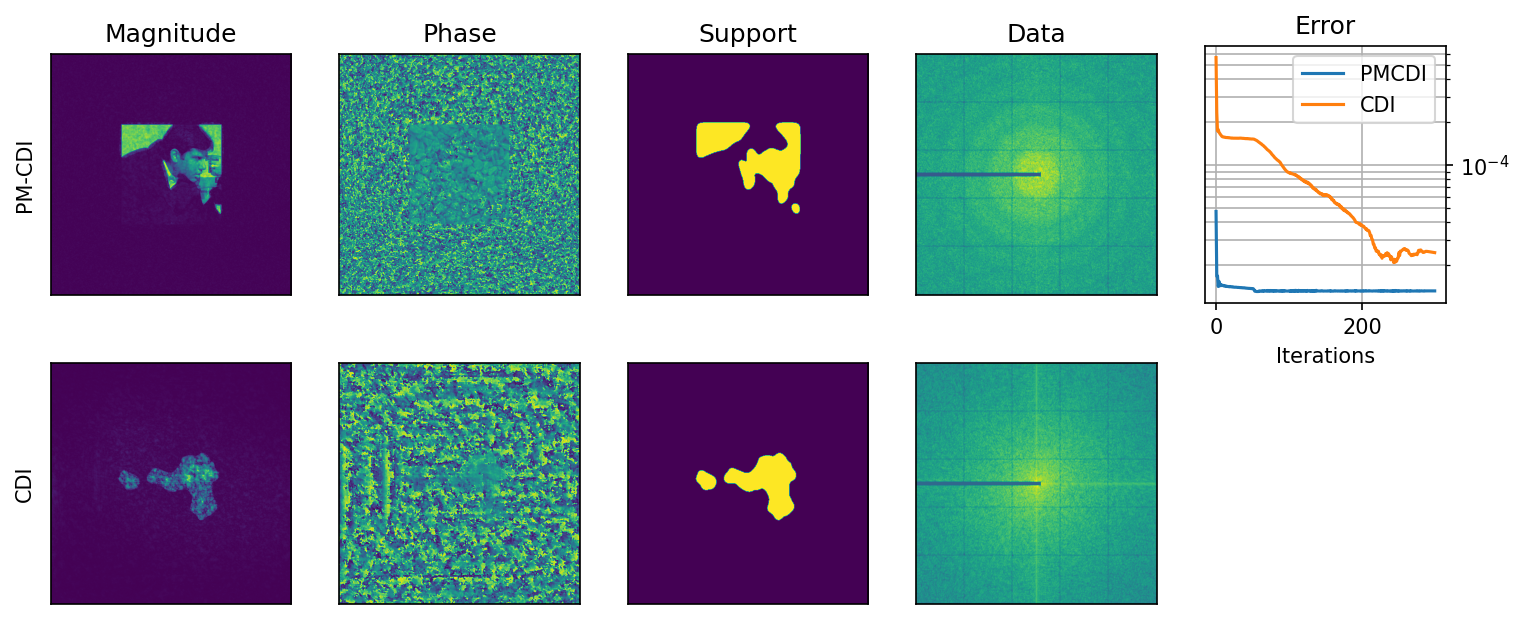

In [44]:
fig, ax = plt.subplots(2,5,figsize=(12,5),dpi=150)
ax[0,0].imshow(np.abs(result_CMI))
ax[0,0].set_title('Magnitude')
ax[0,1].imshow(np.angle(result_CMI))
ax[0,1].set_title('Phase')
ax[0,2].imshow(np.abs(final_support_CMI))
ax[0,2].set_title('Support')
ax[0,3].imshow(np.abs(corrupted_measurement),norm=LogNorm())
ax[0,3].set_title('Data')
ax[0,0].set_ylabel('PM-CDI')
ax[0,4].plot(error_CMI,label='PMCDI')
ax[0,4].set_title('Error')

ax[1,0].imshow(np.abs(result_CDI))
ax[1,1].imshow(np.angle(result_CDI))
ax[1,2].imshow(np.abs(final_support_CDI))
ax[1,0].set_ylabel('CDI')
ax[1,3].imshow(np.abs(corrupted_measurement_without_modulator),norm=LogNorm())
ax[0,4].plot(error_CDI,label='CDI')

ax[0,4].set_yscale('log')
ax[0,4].yaxis.set_ticks_position("right")
ax[0,4].grid(which='both')
ax[0,4].set_xlabel('Iterations')
ax[0,4].legend()
fig.delaxes(ax[1,4])

for ax0 in ax.ravel():
    if ax0 == ax[0,4] or ax0 == ax[1,4]:
        pass
    else:
        ax0.set_xticks([])
        ax0.set_yticks([]) 
